# Problem 1: Call center data modeling

We start by copying the functions defined during breakout activity in class session 2.2

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt(
    'https://course-resources.minerva.kgi.edu/uploaded_files/mke/'
    '00124343-8397/call-center.csv')

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

In [3]:
def prior(lambda_):
    return sts.gamma(1, scale=1/0.25).pdf(lambda_)

def likelihood(lambda_, datum):
    return sts.expon(scale=1/lambda_).pdf(datum)

def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

def compute_percentile(parameter_values, distribution_values, percentile):
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]

Now to find the 98% posterior confidence interval and the posterior mean for each hour of the day

In [4]:
percentiles_list = []
for hour_index in range(len(waiting_times_per_hour)):
    waiting_times_hour = waiting_times_per_hour[hour_index]
    lambdas = np.linspace(0, 20, 501)[1:]
    posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)

    percentiles = [compute_percentile(lambdas, posterior, p) for p in [0.01, 0.99]]
    percentiles_list.append(percentiles)
    

posterior_means = []
for percentile in percentiles_list:
    mean = (percentile[0]+percentile[1])/2
    posterior_means.append(mean)

In [5]:
res = "\n".join("{} {}".format(x, y) for x, y in zip(posterior_means, percentiles_list))
print("Lambda Mean | Confidence Interval \n")
print(res)

Lambda Mean | Confidence Interval 

0.12000000000000001 [0.04, 0.2]
0.1 [0.04, 0.16]
0.1 [0.04, 0.16]
0.26 [0.08, 0.44]
0.44 [0.24, 0.64]
0.8999999999999999 [0.6, 1.2]
1.58 [1.2, 1.96]
2.88 [2.36, 3.4]
4.26 [3.64, 4.88]
5.720000000000001 [5.0, 6.44]
8.280000000000001 [7.4, 9.16]
15.34 [14.16, 16.52]
14.260000000000002 [13.120000000000001, 15.4]
6.36 [5.6000000000000005, 7.12]
3.1 [2.56, 3.64]
3.44 [2.88, 4.0]
4.38 [3.7600000000000002, 5.0]
6.98 [6.2, 7.76]
8.8 [7.92, 9.68]
6.66 [5.88, 7.44]
2.3000000000000003 [1.84, 2.7600000000000002]
0.8400000000000001 [0.56, 1.12]
0.34 [0.16, 0.52]
0.3 [0.12, 0.48]


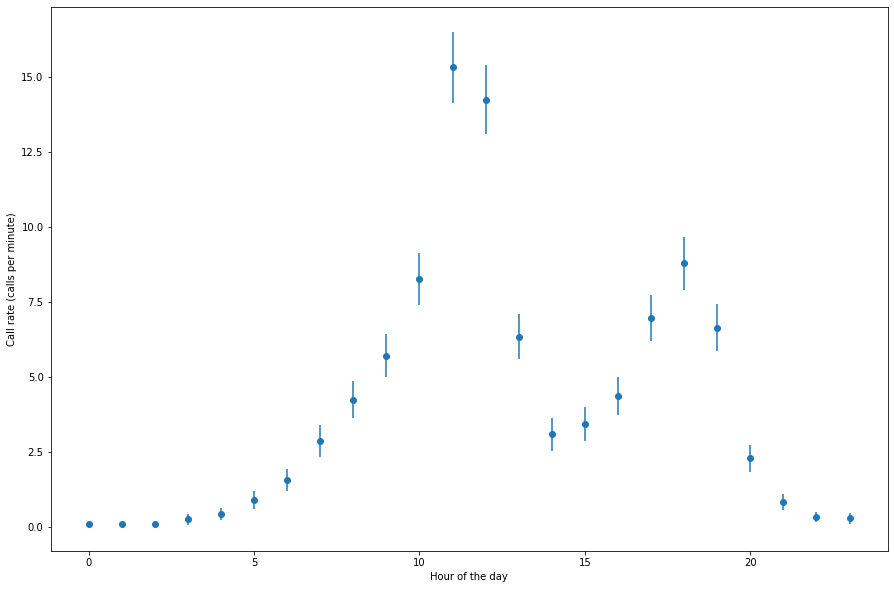

In [6]:
plt.figure(figsize=(15,10))
plt.errorbar(range(24), posterior_means, 
             [(interval[1]-interval[0])/2 for interval in percentiles_list],
            fmt='o')
plt.xlabel('Hour of the day')
plt.ylabel('Call rate (calls per minute)')
plt.show()

From the plot, we can see how the call rates vary throughout the day. Depending on which hour, we see that there is a lot of variation with most calls coming between 10:00 and 13:00. The periods with least activity are late night and early morning which is from 21:00 to 5:00. Those numbers are reasonable and seem to reflect how a work day usually goes, with most people calling during lunch time and a second, smaller peak between 17:00 and 19:00, which are the times where clients are most free to call.

From the graph, we can also see the uncertainty surrounding our estimates. With the dots being the mean number of expected calls and the surrounding error bars reflecting a 98% confidence interval (the values where the likely true rate lies). This is a high confidence number, so we can be confident in our predictions. However, this range of values changes depending on the hour of the day, so for certain hours the possible values are tighter than others.

For the least busy hours, the range of values is small, however, for the busy times, this varies greatly. It's important to take note of this when preparing to address clients (such as deciding how many attendants should be on the phone). For example, in hour 11:00, the possible values at this confidence interval are [14.16, 16.52], meaning we would have to be just as ready to prepare for both of these rates.

Lastly, our predictions could always improve by gathering more data. The more we have, the narrower our confidence interval will be and more certain we can be of what are the true call rate values throughout the day.


# Problem 2: Bent coin inference

We want to find P(pi|x), where pi is the success parameter (the probability of coin coming up heads) and x is the data. To achieve this, we use Bayesian inference

The Beta distribution is conjugate prior to the Binomial distribution, as such, we can easily calculate the parameters of the posterior distribution from the parameters of the prior distribution and the data.


$$
\begin{align}
  \alpha_{\text{post}} &= \alpha + \sum_{i=1}^n x_i  \\
  \beta_{\text{post}} &= \beta + \sum_{i=1}^n N_1 - \sum_{i=1}^n x_i
     {}{}
\end{align}
$$

In [7]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

n = 20 #number of trials
x = 6 #number of heads

a = 0.5
b = 0.5

a_post = a + x
b_post = b + n - x

distribution = sts.beta(a = a_post, b = b_post)

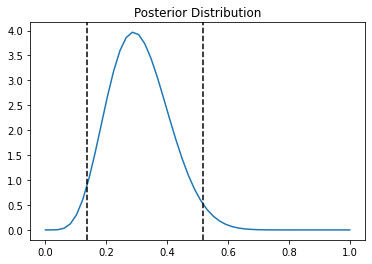

Posterior Mean 0.3033772741576859
Pr biased for heads: 3.54735868012932 %
95% Confidence Interval: (0.1361162265871905, 0.5172282485669721)


In [8]:
x = np.linspace(0,1)

cdf = (1 - distribution.cdf([0.5]))*100
confidence = distribution.interval(0.95)

plt.figure()
plt.title('Posterior Distribution')
plt.plot(x, distribution.pdf(x))
plt.axvline(confidence[0], linestyle='dashed', color="black")
plt.axvline(confidence[1], linestyle='dashed', color="black")
plt.show()

print('Posterior Mean', distribution.ppf([0.5])[0])
print(f'Pr biased for heads: {cdf[0]} %')
print(f'95% Confidence Interval: {confidence}')

For the parameters of the prior distribution, we choose 1 for both alpha and beta. This would represent an arcsine prior, and we choose this approach because we have absence of knowledge about the parameter value pi (the only thing we know is that the coin is bent, but not for which side). Therefore, we intentionally choose an uninformative prior.

The 95% confidence interval of pi is represented by the dashed lines in the plot, which is where the likely true value of our parameter pi lies on. The confidence interval is from 0.13 to 0.517, with posterior mean of 0.30

To compute the probability that the coin is biased in favor of heads, we calculate 1 - cumulative distribution function at point 0.5. This essentially gives us the area to the right of the posterior where the parameter is above 0.5, which is the same as stating where the bias flips in favor of tails to heads. We find that this probability is of 3.54%